In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set()

from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
sim_metadata_fold = "../../../data/carla_sim/random_spawn/"
sim_responses_fold = "../../../data/experiments/carla_sim/random_spawn/"
sim_manual_rec_fold = "../../../data/experiments/carla_sim/manual_recorded_scenes/"

samples = os.listdir(sim_metadata_fold)

In [58]:
samples

['example_0',
 'example_1',
 'example_10',
 'example_100',
 'example_101',
 'example_102',
 'example_103',
 'example_104',
 'example_105',
 'example_106',
 'example_107',
 'example_108',
 'example_109',
 'example_11',
 'example_110',
 'example_111',
 'example_112',
 'example_113',
 'example_114',
 'example_27',
 'example_28',
 'example_29',
 'example_3',
 'example_30',
 'example_31',
 'example_32',
 'example_33',
 'example_34',
 'example_35',
 'example_36',
 'example_37',
 'example_38',
 'example_39',
 'example_4',
 'example_40',
 'example_41',
 'example_42',
 'example_43',
 'example_45',
 'example_46',
 'example_47',
 'example_48',
 'example_49',
 'example_5',
 'example_50',
 'example_51',
 'example_52',
 'example_53',
 'example_54',
 'example_55',
 'example_56',
 'example_57',
 'example_58',
 'example_59',
 'example_6',
 'example_60',
 'example_61',
 'example_63',
 'example_64',
 'example_65',
 'example_66',
 'example_67',
 'example_68',
 'example_69',
 'example_7',
 'example_70',
 '

In [3]:
df_metadata = pd.DataFrame(columns=["sample_id", "coll_type", "t_end", "vel", "diameter", "dt"])

for sample in samples:
    smd = np.load(sim_metadata_fold + sample + "/sim_data.npz", allow_pickle=True)
    df_metadata = pd.concat(
        [
            df_metadata,
            pd.DataFrame(
                {
                    "sample_id": sample.split("_")[1],
                    "coll_type": [smd["coll_type"][()]],
                    "t_end": [smd["t_end"][()]],
                    "vel": [smd["vel"][()]],
                    "diameter": [smd["diameter_object"][()]],
                    "dt": [smd["dt"][()]],
                }
            ),
        ], ignore_index=True
    )

df_metadata['coll_type'].replace(to_replace=[None], value='none', inplace=True)

/tmp/ipykernel_3991/2689157384.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metadata = pd.concat(


In [7]:
df_metadata

,sample_id,coll_type,coll_time,t_end,vel,diameter,dt
0,0,cars,2429,2429,4.529172,2.612508,10.0
1,1,pedestrians,1659,1659,7.947197,0.889352,10.0
2,10,none,4000,4000,7.946603,NaN,10.0
3,100,pedestrians,1659,1659,7.947036,0.929854,10.0
4,101,cars,1399,1399,7.945492,2.727977,10.0
...,...,...,...,...,...,...,...
128,21,none,4009,4009,6.572920,NaN,10.0
129,22,cars,1499,1499,7.947430,2.826570,10.0
130,23,none,4009,4009,7.946305,NaN,10.0
131,24,none,4009,4009,6.994802,NaN,10.0


In [5]:
#models = ["EMD"]#["LGMD", "EMD"]
#models = ["LGMD"]
models = ["EMD"]
tiles = [3]

N_SUBSAMPLE = 5

tile_id_range_y = {3: (1,1), 5: (1,2,3), 7: (2,3,4)}

df_responses = pd.DataFrame(
    columns=[
        "sample_id",
        "model",
        "n tiles",
        "tile_idx_y",
        "tile_idx_x",
        "coll_type",
        "coll_time",
        "vel",
        "diameter",
        "voltage",
        "r left",
        "r right",
        "time",
    ]
)

for model in models:
    print(model)
    for ntile in tiles:
        print(ntile)
        for sample in samples:
            try:
                sample_id = sample.split("_")[1]
                sample_metadata = df_metadata[df_metadata["sample_id"] == sample_id].iloc[0]
                smd = np.load(os.path.join(sim_responses_fold, model, str(ntile) + "_tiles", sample + ".npz"))

                time_ax = (np.arange(smd["v_out"].shape[2]) - (sample_metadata["t_end"]/sample_metadata["dt"]).astype(int)) * sample_metadata["dt"]
                voltage = smd["v_out"]
                r_left = smd["r_left_out"]
                r_right = smd["r_right_out"]

                for idx_x in range(ntile):
                    for idx_y in tile_id_range_y[ntile]:
                        df_responses = pd.concat([df_responses, pd.DataFrame({
                            "sample_id": sample_id,
                            "model": model,
                            "n tiles": ntile,
                            "tile_idx_x": idx_x,
                            "tile_idx_y": idx_y,
                            "coll_type": sample_metadata["coll_type"],
                            "coll_time": sample_metadata["t_end"],
                            "vel": sample_metadata["vel"],
                            "diameter": sample_metadata["diameter"],
                            "voltage": voltage[idx_y, idx_x],
                            "r left": r_left[idx_y, idx_x],
                            "r right": r_right[idx_y, idx_x],
                            "time": time_ax#(((sample_metadata["dt"] * np.arange(smd["v_out"].shape[2]) - sample_metadata["t_end"]))/T_SUBSAMPLE).astype(int) * T_SUBSAMPLE,
                        })], ignore_index=True)

            except OSError as e:
                #print("could not find file")
                pass

time_ax = np.sort(df_responses["time"].unique())
time_ax_subsample = time_ax[::N_SUBSAMPLE]

df_responses = df_responses[df_responses["time"].isin(time_ax_subsample)]
df_responses = df_responses[df_responses["time"] <= 0.0]

EMD
3


/tmp/ipykernel_3860/3116808078.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_responses = pd.concat([df_responses, pd.DataFrame({


In [5]:
df_responses['time'] = pd.to_numeric(df_responses['time'])
df_responses["n tiles"] = pd.to_numeric(df_responses["n tiles"])
df_responses["coll_time"] = pd.to_numeric(df_responses["coll_time"])
df_responses["voltage"] = pd.to_numeric(df_responses["voltage"]).astype(float)
df_responses["r left"] = pd.to_numeric(df_responses["r left"]).astype(float)
df_responses["r right"] = pd.to_numeric(df_responses["r right"]).astype(float)
df_responses["Output Voltage"] = df_responses["voltage"]
df_responses["Output Voltage Linear"] = 0.5 * (df_responses["r left"] + df_responses["r right"])
df_responses['L/v'] = df_responses['diameter'] / df_responses['vel']
df_responses['Collision Type'] = df_responses['coll_type'].map({'none': 'No Collision', 'cars': 'Cars', 'pedestrians': 'Pedestrians'})

In [42]:
df_responses.to_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [4]:
df_responses = pd.read_csv(os.path.join(sim_responses_fold, "responses.csv"))

In [5]:
df_responses

,Unnamed: 0,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,voltage,r left,r right,time,Output Voltage,L/v,Collision Type
0,0,0,EMD,3,1,0,pedestrians,1909,9.346452,0.887657,0.000000,0.000000,0.000000,-1900.0,0.000000,0.094973,Pedestrians
1,5,0,EMD,3,1,0,pedestrians,1909,9.346452,0.887657,0.000080,0.020688,0.012647,-1850.0,0.000080,0.094973,Pedestrians
2,10,0,EMD,3,1,0,pedestrians,1909,9.346452,0.887657,0.001512,0.053805,0.058303,-1800.0,0.001512,0.094973,Pedestrians
3,15,0,EMD,3,1,0,pedestrians,1909,9.346452,0.887657,0.002697,0.035886,0.059455,-1750.0,0.002697,0.094973,Pedestrians
4,20,0,EMD,3,1,0,pedestrians,1909,9.346452,0.887657,0.002308,0.028147,0.044894,-1700.0,0.002308,0.094973,Pedestrians
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83125,414939,259,EMD,3,1,2,cars,2159,9.657932,2.179474,-0.001261,-0.062565,0.507791,-200.0,-0.001261,0.225667,Cars
83126,414944,259,EMD,3,1,2,cars,2159,9.657932,2.179474,0.001823,0.037636,0.825039,-150.0,0.001823,0.225667,Cars
83127,414949,259,EMD,3,1,2,cars,2159,9.657932,2.179474,0.031509,0.116393,0.932456,-100.0,0.031509,0.225667,Cars
83128,414954,259,EMD,3,1,2,cars,2159,9.657932,2.179474,0.100129,0.202489,0.817187,-50.0,0.100129,0.225667,Cars


In [4]:
df_responses.groupby(["coll_type"])["sample_id"].nunique()

coll_type
cars           79
none           89
pedestrians    89
Name: sample_id, dtype: int64

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

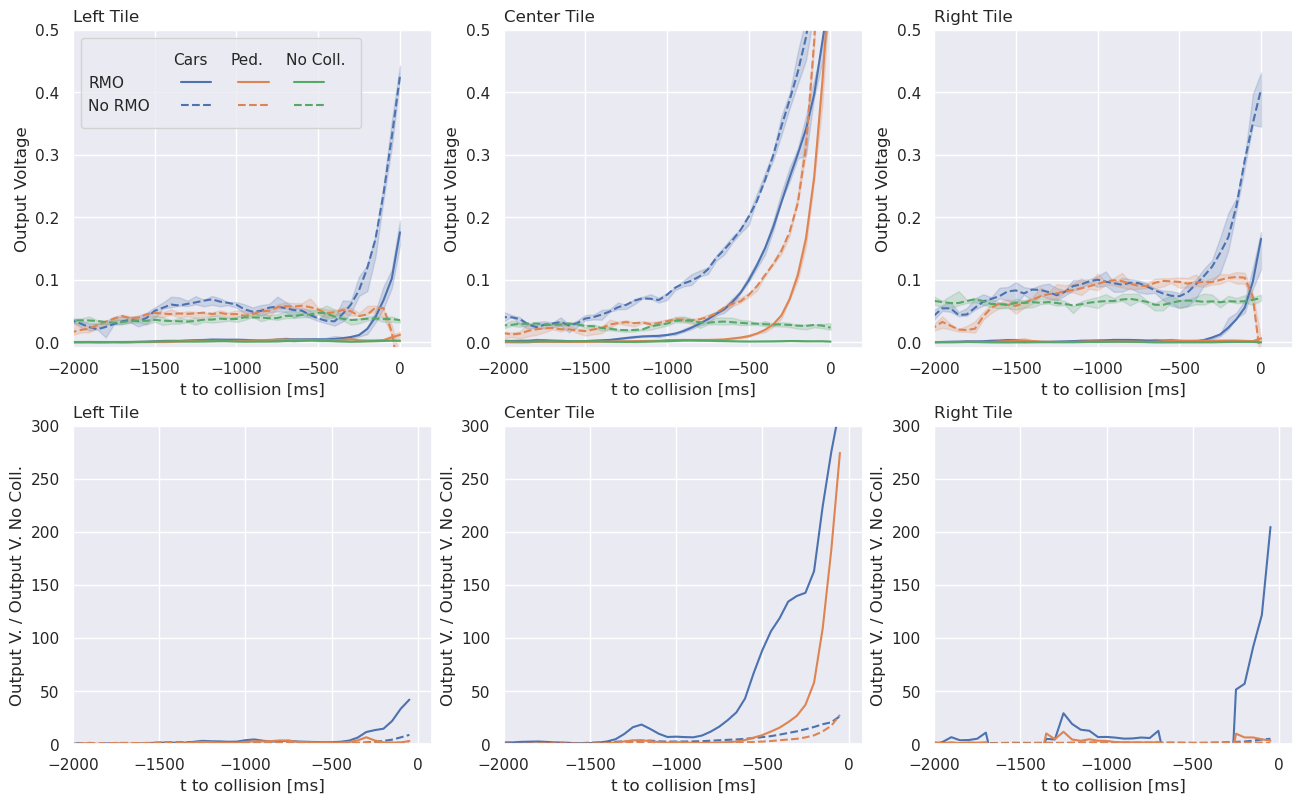

In [214]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(2, 3, figsize=(13, 8))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import matplotlib.patches as m_patches

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]
patches_column4 = [m_patches.Patch(color="none", label="No Coll.")]

for k, _ax in enumerate(ax[0]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    _o_cars = sns.lineplot(
        x="time",
        y="Output Voltage",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        label="*",
        legend=False,
    )

    _o_cars_linear = sns.lineplot(
        x="time",
        y="Output Voltage Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "cars"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[0],
        linestyle="--",
        label="*",
        legend=False,
    )
    

    _o_pedestrians = sns.lineplot(
        x="time",
        y="Output Voltage",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        label="*",
        legend=False,
    )

    _o_pedestrians_linear = sns.lineplot(
        x="time",
        y="Output Voltage Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "pedestrians"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[1],
        linestyle="--",
        label="*",
        legend=False,
    )

    

    _o_none = sns.lineplot(
        x="time",
        y="Output Voltage",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "none"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        label="*",
        legend=False,
    )

    _o_none_linear = sns.lineplot(
        x="time",
        y="Output Voltage Linear",
        # estimator=None,#"mean",
        # units="sample_id",
        data=_df_temp[_df_temp["coll_type"] == "none"],
        sort=True,
        # errorbar="se",
        orient="x",
        n_boot=5,
        ax=_ax,
        color=colors[2],
        linestyle="--",
        label="*",
        legend=False,
    )

    if k == 0:
        _lines = _ax.get_lines()
        patches_column2.extend([_lines[0], _lines[1]])
        patches_column3.extend([_lines[2], _lines[3]])
        patches_column4.extend([_lines[4], _lines[5]])
    
    _ax.set_ylabel("Output Voltage")
    

    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=0.5, bottom=-0.01)

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)
patches.extend(patches_column4)

lg = ax[0,0].legend(
    ncol=4,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8, 10, 11):
        text.set_color("none")

for k, _ax in enumerate(ax[1]):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1) & (df_responses_filt["time"] < 0.0)
    ]

    _mean_resp = _df_temp[["time","coll_type", "Output Voltage", "Output Voltage Linear"]].groupby(["time","coll_type"]).mean().reset_index()

    _filt_cars = _mean_resp["coll_type"]=="cars"
    _filt_pedestrians = _mean_resp["coll_type"]=="pedestrians"
    _filt_none = _mean_resp["coll_type"]=="none"

    _times_intersect = list((set(_mean_resp["time"][_filt_cars]).intersection(set(_mean_resp["time"][_filt_pedestrians]))).intersection(set(_mean_resp["time"][_filt_none])))
 
    _mean_resp = _mean_resp[_mean_resp["time"].isin(_times_intersect)]

    _filt_cars = _mean_resp["coll_type"]=="cars"
    _filt_pedestrians = _mean_resp["coll_type"]=="pedestrians"
    _filt_none = _mean_resp["coll_type"]=="none"

    _ax.plot(list(_mean_resp["time"][_filt_cars]), np.array(list(_mean_resp["Output Voltage"][_filt_cars]))/np.array(list(_mean_resp["Output Voltage"][_filt_none])), color=colors[0])
    _ax.plot(list(_mean_resp["time"][_filt_cars]), np.array(list(_mean_resp["Output Voltage Linear"][_filt_cars]))/np.array(list(_mean_resp["Output Voltage Linear"][_filt_none])), color=colors[0], linestyle="--")

    _ax.plot(list(_mean_resp["time"][_filt_pedestrians]), np.array(list(_mean_resp["Output Voltage"][_filt_pedestrians]))/np.array(list(_mean_resp["Output Voltage"][_filt_none])), color=colors[1])
    _ax.plot(list(_mean_resp["time"][_filt_pedestrians]), np.array(list(_mean_resp["Output Voltage Linear"][_filt_pedestrians]))/np.array(list(_mean_resp["Output Voltage Linear"][_filt_none])), color=colors[1], linestyle="--")

    # / _mean_resp["Output Voltage"][_filt_none].reset_index()

    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=300., bottom=-0.01)

    _ax.set_ylabel("Output V. / Output V. No Coll.")

    #_ax.set_yscale("log")

ax[0,0].set_title("Left Tile", loc="left")
ax[0,1].set_title("Center Tile", loc="left")
ax[0,2].set_title("Right Tile", loc="left")

ax[1,0].set_title("Left Tile", loc="left")
ax[1,1].set_title("Center Tile", loc="left")
ax[1,2].set_title("Right Tile", loc="left")

fig.tight_layout(pad=0.5)

fig.savefig("responses_emd_3_tile.png", dpi=400)
fig.savefig("responses_emd_3_tile.pdf")

plt.show()

In [205]:
len(ax[0,0].get_lines())

6

In [157]:
print(_mean_resp[_mean_resp["coll_type"]=="cars"])
print(len(_mean_resp[_mean_resp["coll_type"]=="cars"]))

       time coll_type  Output Voltage  Output Voltage Linear
46  -2700.0      cars        0.000089               0.024418
49  -2650.0      cars        0.000528               0.032792
52  -2600.0      cars        0.000688               0.022415
55  -2550.0      cars        0.000674               0.023071
58  -2500.0      cars        0.001202               0.038728
61  -2450.0      cars        0.002488               0.046316
64  -2400.0      cars        0.003198               0.030763
67  -2350.0      cars        0.004096               0.029494
70  -2300.0      cars        0.003101               0.022702
73  -2250.0      cars        0.003085               0.029361
76  -2200.0      cars        0.002385               0.053428
79  -2150.0      cars        0.001252               0.055281
82  -2100.0      cars        0.000665               0.050729
85  -2050.0      cars        0.000158               0.040091
88  -2000.0      cars        0.000200               0.034313
91  -1950.0      cars   

In [158]:
print(_mean_resp[_mean_resp["coll_type"]=="pedestrians"])
print(len(_mean_resp[_mean_resp["coll_type"]=="pedestrians"]))

       time    coll_type  Output Voltage  Output Voltage Linear
48  -2700.0  pedestrians        0.000000               0.000000
51  -2650.0  pedestrians        0.000237               0.006231
54  -2600.0  pedestrians       -0.000104               0.006748
57  -2550.0  pedestrians       -0.000274               0.005046
60  -2500.0  pedestrians       -0.000229               0.003261
63  -2450.0  pedestrians       -0.000092               0.014593
66  -2400.0  pedestrians        0.000475               0.022870
69  -2350.0  pedestrians        0.000996               0.021776
72  -2300.0  pedestrians        0.000342               0.011485
75  -2250.0  pedestrians        0.000124               0.014437
78  -2200.0  pedestrians        0.000265               0.023032
81  -2150.0  pedestrians        0.000156               0.027322
84  -2100.0  pedestrians        0.000080               0.026012
87  -2050.0  pedestrians       -0.000148               0.023701
90  -2000.0  pedestrians       -0.000185

In [159]:
print(_mean_resp[_mean_resp["coll_type"]=="none"])
print(len(_mean_resp[_mean_resp["coll_type"]=="none"]))

       time coll_type  Output Voltage  Output Voltage Linear
47  -2700.0      none        0.001254               0.036687
50  -2650.0      none        0.001486               0.033051
53  -2600.0      none        0.001701               0.033701
56  -2550.0      none        0.001604               0.035757
59  -2500.0      none        0.001414               0.036905
62  -2450.0      none        0.001332               0.037883
65  -2400.0      none        0.001371               0.037700
68  -2350.0      none        0.001515               0.036162
71  -2300.0      none        0.001151               0.035482
74  -2250.0      none        0.000791               0.036908
77  -2200.0      none        0.000483               0.035660
80  -2150.0      none        0.000299               0.035106
83  -2100.0      none        0.000304               0.034551
86  -2050.0      none        0.000368               0.033968
89  -2000.0      none        0.000294               0.034640
92  -1950.0      none   

In [170]:
_mean_resp["Output Voltage"][_filt_cars].reset_index() / _mean_resp["Output Voltage"][_filt_none].reset_index()

,index,Output Voltage
0,0.978723,0.070724
1,0.980000,0.355142
2,0.981132,0.404619
3,0.982143,0.420420
4,0.983051,0.850192
5,0.983871,1.868018
6,0.984615,2.333371
7,0.985294,2.704028
8,0.985915,2.692986
9,0.986486,3.903056


In [184]:
list(_mean_resp["time"][_filt_cars])

[-2700.0,
 -2650.0,
 -2600.0,
 -2550.0,
 -2500.0,
 -2450.0,
 -2400.0,
 -2350.0,
 -2300.0,
 -2250.0,
 -2200.0,
 -2150.0,
 -2100.0,
 -2050.0,
 -2000.0,
 -1950.0,
 -1900.0,
 -1850.0,
 -1800.0,
 -1750.0,
 -1700.0,
 -1650.0,
 -1600.0,
 -1550.0,
 -1500.0,
 -1450.0,
 -1400.0,
 -1350.0,
 -1300.0,
 -1250.0,
 -1200.0,
 -1150.0,
 -1100.0,
 -1050.0,
 -1000.0,
 -950.0,
 -900.0,
 -850.0,
 -800.0,
 -750.0,
 -700.0,
 -650.0,
 -600.0,
 -550.0,
 -500.0,
 -450.0,
 -400.0,
 -350.0,
 -300.0,
 -250.0,
 -200.0,
 -150.0,
 -100.0,
 -50.0]

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

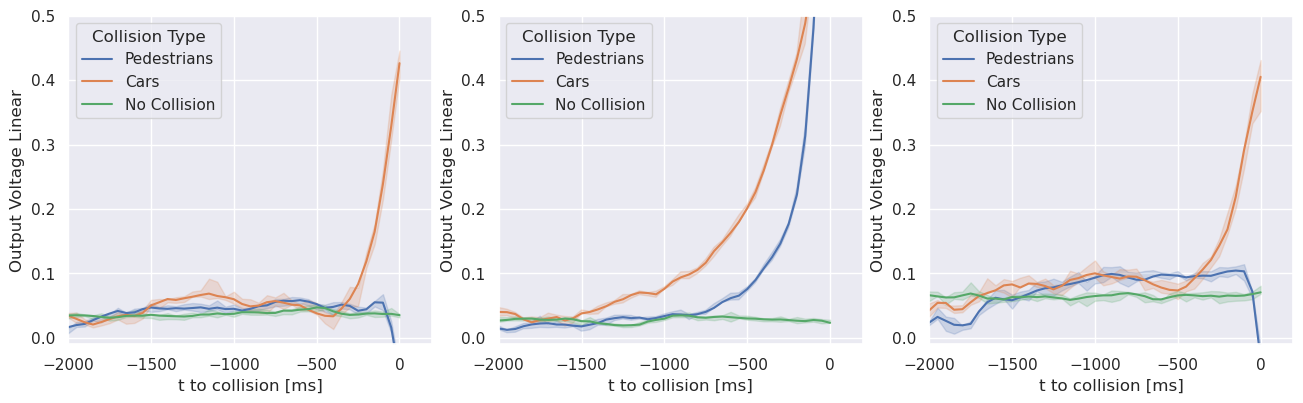

In [25]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="Output Voltage Linear",
        #estimator=None,#"mean",
        #units="sample_id",
        data=_df_temp,
        sort=True,
        #errorbar="se",
        orient="x",
        hue="Collision Type",
        n_boot=5,
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

    _ax.set_ylim(top=0.5, bottom=-0.01)

fig.tight_layout(pad=0.5)

fig.savefig("responses_emd_linear_3_tile.png", dpi=400)
fig.savefig("responses_emd_linear_3_tile.pdf")

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

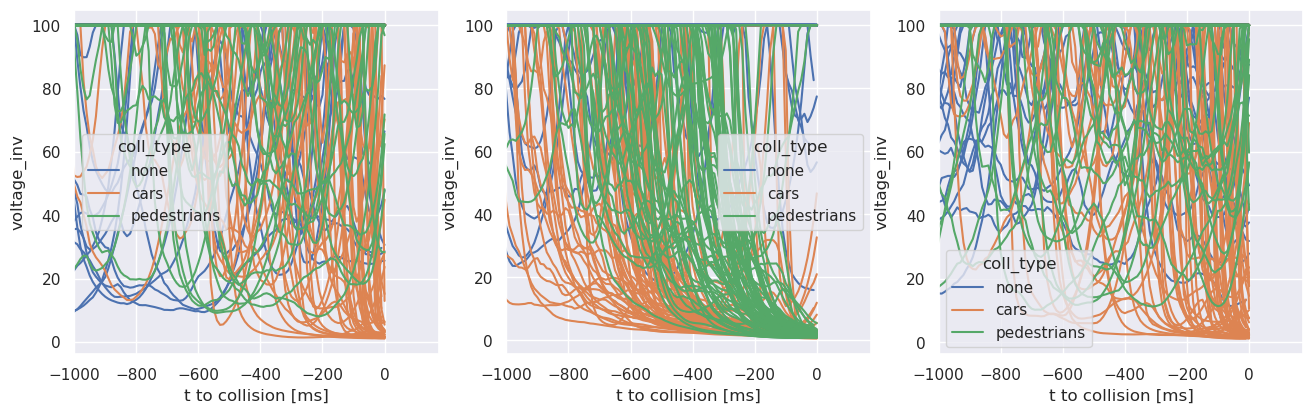

In [55]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage_inv",
        estimator=None,#"mean",
        units="sample_id",
        data=_df_temp,
        sort=True,
        #errorbar="se",
        orient="x",
        hue="coll_type",
        n_boot=5,
        ax=_ax
    )
    _ax.set_xlim(left=-1000)
    _ax.set_xlabel("t to collision [ms]")

    #_ax.set_ylim(top=0.5, bottom=-0.01)

    #_ax.set_yscale("log")
    #_ax.set_xscale("log")

fig.tight_layout(pad=0.2)

fig.savefig("responses_emd_3_tile_log.png", dpi=400)
fig.savefig("responses_emd_3_tile_log.pdf")

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_

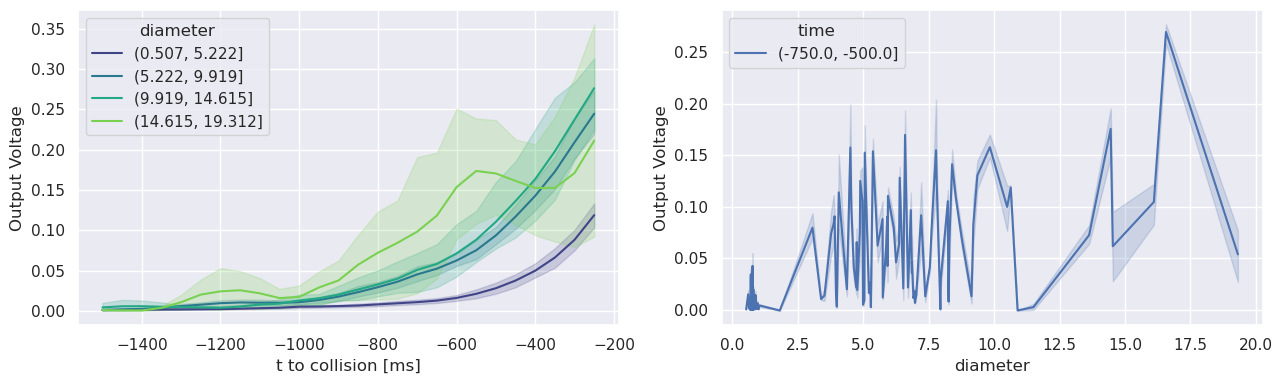

In [252]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3)
    & (df_responses["model"] == "EMD")
    & (df_responses["coll_type"] != "none")
]

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

_df_temp = df_responses_filt[
    (df_responses_filt["tile_idx_x"] == 1)
    & (df_responses_filt["tile_idx_y"] == 1)
    & (df_responses_filt["L/v"] < 1.0)
    & (df_responses_filt.time >= -1500)
    & (df_responses_filt.time <= -250)
]
sns.lineplot(
    x="time",
    y="Output Voltage",
    # estimator="mean",
    data=_df_temp,
    sort=True,
    orient="x",
    hue=pd.cut(_df_temp["diameter"]**2., bins=4),
    palette="viridis",
    ax=ax[0],
    n_boot=100,
)
#ax[0].set_xlim(left=-2000)
ax[0].set_xlabel("t to collision [ms]")

sns.lineplot(
    # x=_df_temp["L/v"] * _df_temp["diameter"] / (-_df_temp["time"] * _df_temp["vel"]),
    x=_df_temp["diameter"]**2.,
    y=_df_temp["Output Voltage"],
    # data=_df_temp[(_df_temp.time >= -750) & (_df_temp.time <= -250)],
    sort=True,
    orient="x",
    hue=pd.cut(_df_temp.time, bins=pd.IntervalIndex.from_tuples([(-750.,-500.)])),
    # palette="viridis",
    ax=ax[1],
    n_boot=100,
)

fig.tight_layout()

fig.savefig("l_v_responses_emd_3_tile.png", dpi=400)
fig.savefig("l_v_responses_emd_3_tile.pdf")

plt.show()

In [200]:
df_responses.groupby(["coll_type"])["L/v"].mean()

coll_type
cars           0.320197
none                NaN
pedestrians    0.150485
Name: L/v, dtype: float64

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

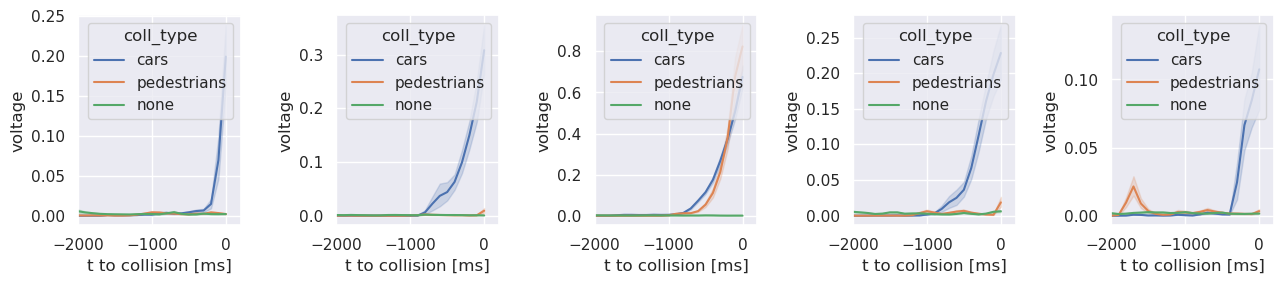

In [94]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 5) & (df_responses["model"] == "EMD")
]

fig, ax = plt.subplots(1, 5, figsize=(13, 3))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 2)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    _ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_emd_5_tile.png", dpi=400)

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

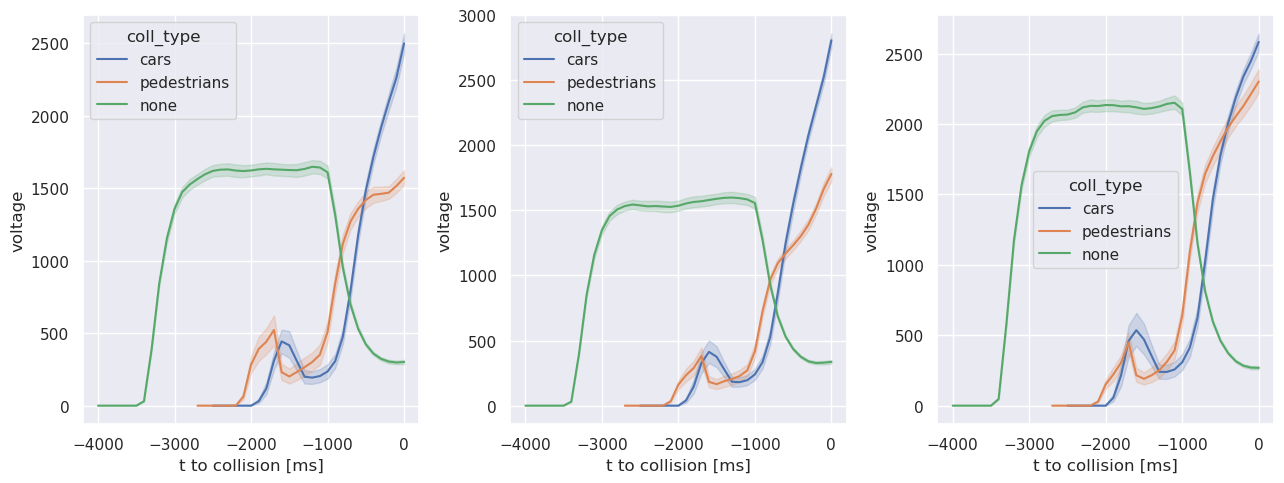

In [119]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 3) & (df_responses["model"] == "LGMD")
]

fig, ax = plt.subplots(1, 3, figsize=(13, 5))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 1)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax
    )
    #_ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_lgmd_3_tile.png", dpi=400)

plt.show()

/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

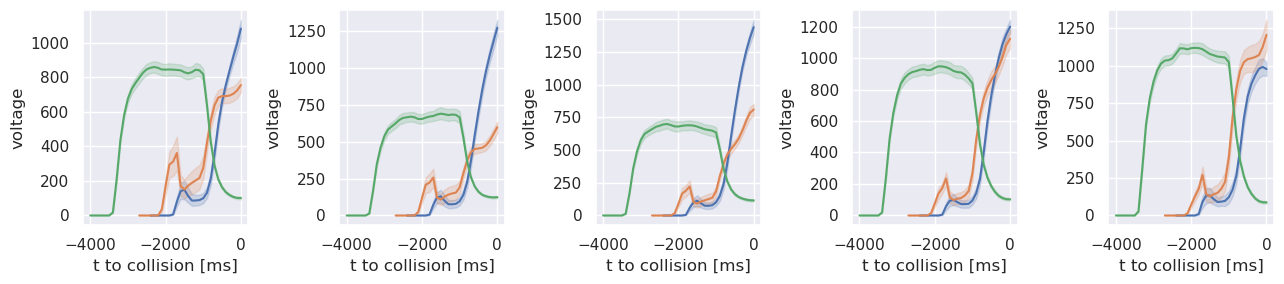

In [101]:
df_responses_filt = df_responses[
    (df_responses["n tiles"] == 5) & (df_responses["model"] == "LGMD")
]

fig, ax = plt.subplots(1, 5, figsize=(13, 3))

for k, _ax in enumerate(ax):
    _df_temp = df_responses_filt[
        (df_responses_filt["tile_idx_x"] == k) & (df_responses_filt["tile_idx_y"] == 2)
    ]
    sns.lineplot(
        x="time",
        y="voltage",
        estimator="mean",
        data=_df_temp,
        sort=True,
        orient="x",
        hue="coll_type",
        ax=_ax,
        legend=False
    )
    #_ax.set_xlim(left=-2000)
    _ax.set_xlabel("t to collision [ms]")

fig.tight_layout()

fig.savefig("responses_lgmd_5_tile.png", dpi=400)

plt.show()

In [104]:
df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    & (df_responses["tile_idx_x"] == 1)
]

,sample_id,model,n tiles,tile_idx_y,tile_idx_x,coll_type,coll_time,vel,diameter,voltage,time,L/v
1016508,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016509,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016510,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2400,0.576818
1016511,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
1016512,0,EMD,3,1,1,cars,2429,4.529172,2.612508,0.000000,-2300,0.576818
...,...,...,...,...,...,...,...,...,...,...,...,...
1160361,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003490,0,NaN
1160362,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003186,0,NaN
1160363,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003138,0,NaN
1160364,90,EMD,3,1,1,none,4009,7.947014,NaN,0.003515,0,NaN


/tmp/ipykernel_3860/1183667362.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: 

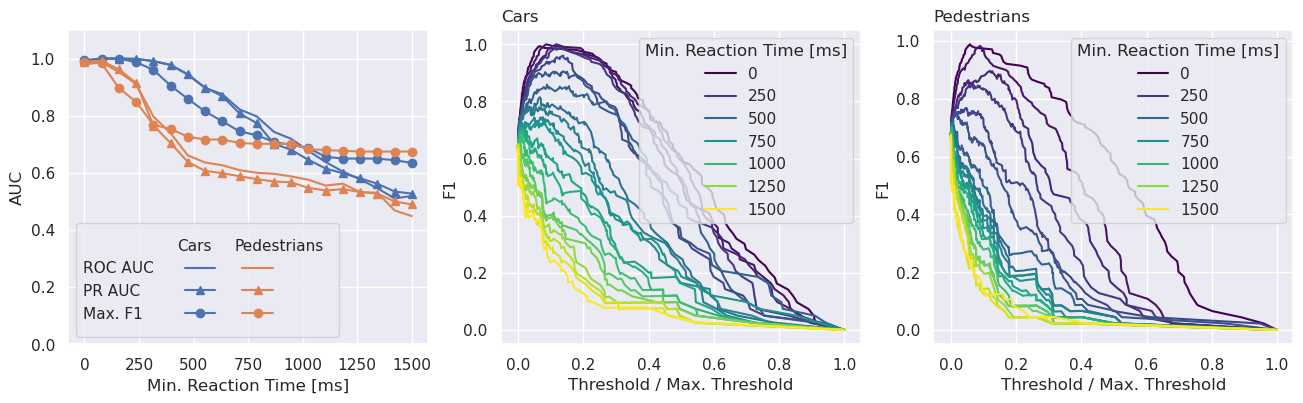

In [34]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

#df_emd["voltage"] += np.random.normal(0, 0.05, len(df_emd))

df_emd["positive"] = df_emd["coll_type"] != "none"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"])
    )

    max_f1_car.append(
        (2 * pr_curve_sweep_car[-1][0][1:] * pr_curve_sweep_car[-1][1][1:] / (pr_curve_sweep_car[-1][0][1:] + pr_curve_sweep_car[-1][1][1:])).max()
    )

    max_f1_pedestrian.append(
        (2 * pr_curve_sweep_pedestrian[-1][0][1:] * pr_curve_sweep_pedestrian[-1][1][1:] / (pr_curve_sweep_pedestrian[-1][0][1:] + pr_curve_sweep_pedestrian[-1][1][1:])).max()
    )

import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
    m_patches.Patch(color="none", label="Max. F1"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "-^", c=colors[0], label="*")
c_max_f1 = ax[0].plot(min_react_time, max_f1_car, "-o", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0], c_max_f1[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "-^", c=colors[1], label="*")
p_max_f1 = ax[0].plot(min_react_time, max_f1_pedestrian, "-o", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0], p_max_f1[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (5, 6, 7, 9, 10, 11):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "coll_type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "cars",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "pedestrians",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd.png", dpi=400)
fig.savefig("roc_pr_emd.pdf")
plt.show()

/tmp/ipykernel_3860/2026932042.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: 

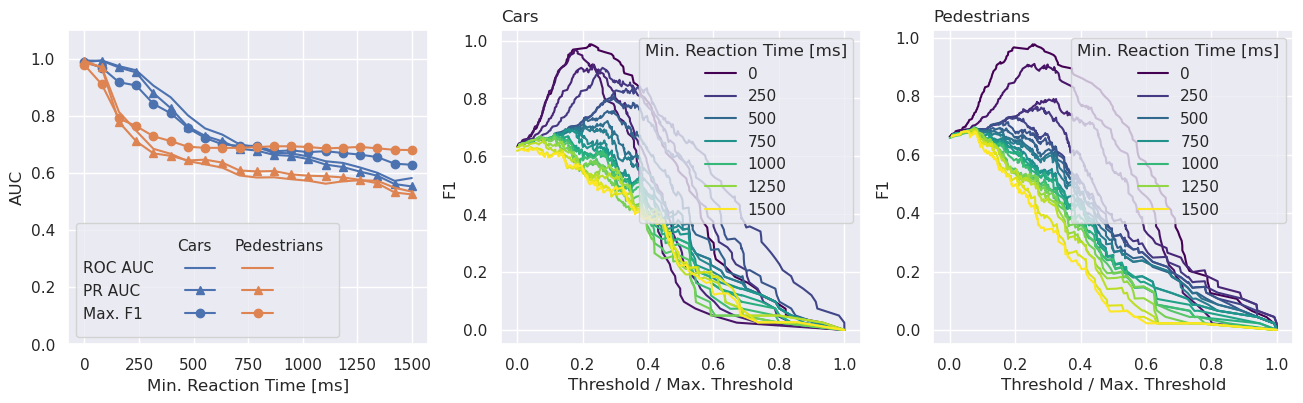

In [35]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

#df_emd["voltage"] += np.random.normal(0, 0.05, len(df_emd))

df_emd["positive"] = df_emd["coll_type"] != "none"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2000.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"])
    )

    max_f1_car.append(
        (2 * pr_curve_sweep_car[-1][0][1:] * pr_curve_sweep_car[-1][1][1:] / (pr_curve_sweep_car[-1][0][1:] + pr_curve_sweep_car[-1][1][1:])).max()
    )

    max_f1_pedestrian.append(
        (2 * pr_curve_sweep_pedestrian[-1][0][1:] * pr_curve_sweep_pedestrian[-1][1][1:] / (pr_curve_sweep_pedestrian[-1][0][1:] + pr_curve_sweep_pedestrian[-1][1][1:])).max()
    )

import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
    m_patches.Patch(color="none", label="Max. F1"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "-^", c=colors[0], label="*")
c_max_f1 = ax[0].plot(min_react_time, max_f1_car, "-o", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0], c_max_f1[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "-^", c=colors[1], label="*")
p_max_f1 = ax[0].plot(min_react_time, max_f1_pedestrian, "-o", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0], p_max_f1[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (5, 6, 7, 9, 10, 11):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "coll_type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "cars",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "pedestrians",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd_linear.png", dpi=400)
fig.savefig("roc_pr_emd_linear.pdf")
plt.show()

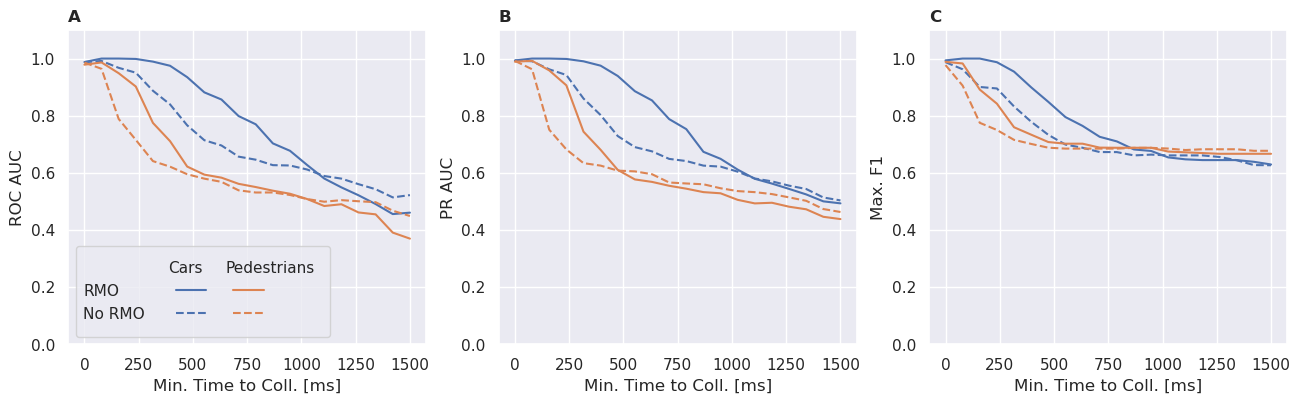

In [130]:
df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
].copy()

#df_emd["voltage"] += np.random.normal(0, 0.05, len(df_emd))

df_emd["positive"] = df_emd["coll_type"] != "none"
#df_emd.loc[df_emd["coll_type"] == "none", "time"] += 2500.0

n_sweep = 20

min_react_time = np.linspace(0.0, 1500.0, n_sweep)

roc_car = []
roc_pedestrian = []
aupr_car = []
aupr_pedestrian = []

roc_curve_sweep_car = []
roc_curve_sweep_pedestrian = []

pr_curve_sweep_car = []
pr_curve_sweep_pedestrian = []

max_f1_car = []
max_f1_pedestrian = []

for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2500.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2500.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"]))
    aupr_car.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"]))
    roc_curve_sweep_car.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"])
    )

    roc_pedestrian.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"]))
    aupr_pedestrian.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"]))
    roc_curve_sweep_pedestrian.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"])
    )

    pr_curve_sweep_car.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["voltage"])
    )
    pr_curve_sweep_pedestrian.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["voltage"])
    )

    max_f1_car.append(
        (2 * pr_curve_sweep_car[-1][0][1:] * pr_curve_sweep_car[-1][1][1:] / (pr_curve_sweep_car[-1][0][1:] + pr_curve_sweep_car[-1][1][1:])).max()
    )

    max_f1_pedestrian.append(
        (2 * pr_curve_sweep_pedestrian[-1][0][1:] * pr_curve_sweep_pedestrian[-1][1][1:] / (pr_curve_sweep_pedestrian[-1][0][1:] + pr_curve_sweep_pedestrian[-1][1][1:])).max()
    )


roc_car_linear = []
roc_pedestrian_linear = []
aupr_car_linear = []
aupr_pedestrian_linear = []

roc_curve_sweep_car_linear = []
roc_curve_sweep_pedestrian_linear = []

pr_curve_sweep_car_linear = []
pr_curve_sweep_pedestrian_linear = []

max_f1_car_linear = []
max_f1_pedestrian_linear = []


for t in min_react_time:
    _df_car = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2500.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

    _df_pedestrian = df_emd[
        ((df_emd["time"] <= -t) & (df_emd["time"] > -2500.)) & (df_emd["coll_type"] != "cars")
    ].copy()

    df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

    df_emd_max_resp_pedestrian = (
        _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
    )

    roc_car_linear.append(roc_auc_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"]))
    aupr_car_linear.append(average_precision_score(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"]))
    roc_curve_sweep_car_linear.append(
        roc_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"])
    )

    roc_pedestrian_linear.append(roc_auc_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"]))
    aupr_pedestrian_linear.append(average_precision_score(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"]))
    roc_curve_sweep_pedestrian_linear.append(
        roc_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"])
    )

    pr_curve_sweep_car_linear.append(
        precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"])
    )
    pr_curve_sweep_pedestrian_linear.append(
        precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"])
    )

    max_f1_car_linear.append(
        (2 * pr_curve_sweep_car_linear[-1][0][1:] * pr_curve_sweep_car_linear[-1][1][1:] / (pr_curve_sweep_car_linear[-1][0][1:] + pr_curve_sweep_car_linear[-1][1][1:])).max()
    )

    max_f1_pedestrian_linear.append(
        (2 * pr_curve_sweep_pedestrian_linear[-1][0][1:] * pr_curve_sweep_pedestrian_linear[-1][1][1:] / (pr_curve_sweep_pedestrian_linear[-1][0][1:] + pr_curve_sweep_pedestrian_linear[-1][1][1:])).max()
    )


import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_roc_linear = ax[0].plot(min_react_time, roc_car_linear, "--", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_roc_linear[0]])

p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_roc_linear = ax[0].plot(min_react_time, roc_pedestrian_linear, "--", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_roc_linear[0]])

c_aupr = ax[1].plot(min_react_time, aupr_car, "-", c=colors[0], label="*")
c_aupr_linear = ax[1].plot(min_react_time, aupr_car_linear, "--", c=colors[0], label="*")
p_aupr = ax[1].plot(min_react_time, aupr_pedestrian, "-", c=colors[1], label="*")
p_aupr_linear = ax[1].plot(min_react_time, aupr_pedestrian_linear, "--", c=colors[1], label="*")

c_max_f1 = ax[2].plot(min_react_time, max_f1_car, "-", c=colors[0], label="*")
c_max_f1_linear = ax[2].plot(min_react_time, max_f1_car_linear, "--", c=colors[0], label="*")
p_max_f1 = ax[2].plot(min_react_time, max_f1_pedestrian, "-", c=colors[1], label="*")
p_max_f1_linear = ax[2].plot(min_react_time, max_f1_pedestrian_linear, "--", c=colors[1], label="*")


patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)
ax[1].set_ylim(top=1.1, bottom=0.0)
ax[2].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("ROC AUC")
ax[1].set_ylabel("PR AUC")
ax[2].set_ylabel("Max. F1")

ax[0].set_xlabel("Min. Time to Coll. [ms]")
ax[1].set_xlabel("Min. Time to Coll. [ms]")
ax[2].set_xlabel("Min. Time to Coll. [ms]")

ax[0].set_title("A", loc="left", fontweight="bold")
ax[1].set_title("B", loc="left", fontweight="bold")
ax[2].set_title("C", loc="left", fontweight="bold")

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

fig.tight_layout(pad=0.5)
fig.savefig("score_comp_emd.png", dpi=400)
fig.savefig("score_comp_emd.pdf")
plt.show()

In [116]:
np.array([min_react_time, roc_car]).T

array([[0.00000000e+00, 9.87910681e-01],
       [7.89473684e+01, 1.00000000e+00],
       [1.57894737e+02, 1.00000000e+00],
       [2.36842105e+02, 9.98703544e-01],
       [3.15789474e+02, 9.89340248e-01],
       [3.94736842e+02, 9.74791126e-01],
       [4.73684211e+02, 9.34889081e-01],
       [5.52631579e+02, 8.81734370e-01],
       [6.31578947e+02, 8.56669548e-01],
       [7.10526316e+02, 7.98761164e-01],
       [7.89473684e+02, 7.69951023e-01],
       [8.68421053e+02, 7.03111495e-01],
       [9.47368421e+02, 6.77182368e-01],
       [1.02631579e+03, 6.27484875e-01],
       [1.10526316e+03, 5.80092192e-01],
       [1.18421053e+03, 5.49121291e-01],
       [1.26315789e+03, 5.21463555e-01],
       [1.34210526e+03, 4.90636704e-01],
       [1.42105263e+03, 4.55647546e-01],
       [1.50000000e+03, 4.60674157e-01]])

In [129]:
min_react_time[6:8].mean()
np.array(roc_car_linear)[6:8].mean()

0.7402765773552291

In [131]:
th_range = np.linspace(0.0, 2.0, 20)




df_emd = df_responses[
    (df_responses["model"] == "EMD")
    & (df_responses["n tiles"] == 3)
    & (df_responses["tile_idx_y"] == 1)
    #& (df_responses["tile_idx_x"] == 1)
][["sample_id", "coll_type", "time", "Output Voltage", "Output Voltage Linear"]].copy()
df_emd["positive"] = (df_emd["coll_type"] != "none")


_df_car = df_emd[
        ((df_emd["time"] <= 0) & (df_emd["time"] > -2500.)) & (df_emd["coll_type"] != "pedestrians")
    ].copy()

_df_pedestrian = df_emd[
    ((df_emd["time"] <= 0) & (df_emd["time"] > -2500.)) & (df_emd["coll_type"] != "cars")
].copy()

df_emd_max_resp_car = (
        _df_car.groupby(["sample_id", "positive"]).max().reset_index()
    )

df_emd_max_resp_pedestrian = (
    _df_pedestrian.groupby(["sample_id", "positive"]).max().reset_index()
)

pr_car = precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage"])
pr_pedestrian = precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage"])

pr_car_linear = precision_recall_curve(df_emd_max_resp_car["positive"], df_emd_max_resp_car["Output Voltage Linear"])
pr_pedestrian_linear = precision_recall_curve(df_emd_max_resp_pedestrian["positive"], df_emd_max_resp_pedestrian["Output Voltage Linear"])

f1_car = 2 * pr_car[0][1:] * pr_car[1][1:] / (pr_car[0][1:] + pr_car[1][1:])
f1_pedestrian = 2 * pr_pedestrian[0][1:] * pr_pedestrian[1][1:] / (pr_pedestrian[0][1:] + pr_pedestrian[1][1:])

f1_car_linear = 2 * pr_car_linear[0][1:] * pr_car_linear[1][1:] / (pr_car_linear[0][1:] + pr_car_linear[1][1:])
f1_pedestrian_linear = 2 * pr_pedestrian_linear[0][1:] * pr_pedestrian_linear[1][1:] / (pr_pedestrian_linear[0][1:] + pr_pedestrian_linear[1][1:])

df_th = pd.DataFrame(columns=["sample_id", "coll_type", "Reaction Time [ms]", "threshold"])
df_th_linear = pd.DataFrame(columns=["sample_id", "coll_type", "Reaction Time [ms]", "threshold"])

th_range = np.linspace(0.0, 0.8, 100)

for th in pr_car[2]:
    _df_filt = df_emd[(df_emd["Output Voltage"] >= th) & (df_emd["coll_type"] == "cars")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th = pd.concat(
        [
            df_th,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "cars",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

for th in pr_pedestrian[2]:
    _df_filt = df_emd[(df_emd["Output Voltage"] >= th) & (df_emd["coll_type"] == "pedestrians")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th = pd.concat(
        [
            df_th,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "pedestrians",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

for th in pr_car_linear[2]:
    _df_filt = df_emd[(df_emd["Output Voltage Linear"] >= th) & (df_emd["coll_type"] == "cars")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th_linear = pd.concat(
        [
            df_th_linear,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "cars",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

for th in pr_pedestrian_linear[2]:
    _df_filt = df_emd[(df_emd["Output Voltage Linear"] >= th) & (df_emd["coll_type"] == "pedestrians")]
    _df_first_detect = _df_filt.groupby(["sample_id", "coll_type"]).min().reset_index()
    df_th_linear = pd.concat(
        [
            df_th_linear,
            pd.DataFrame(
                {
                    "sample_id": _df_first_detect["sample_id"],
                    "coll_type": "pedestrians",
                    "Detect. Time to Coll. [ms]": -_df_first_detect["time"],
                    "threshold": th,
                }
            ),
        ],
        ignore_index=True,
    )

mean_first_detect_car = df_th[df_th["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()
mean_first_detect_pedestrian = df_th[df_th["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()

mean_first_detect_car_linear = df_th_linear[df_th_linear["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()
mean_first_detect_pedestrian_linear = df_th_linear[df_th_linear["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].mean().reset_index()

sd_first_detect_car = df_th[df_th["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()
sd_first_detect_pedestrian = df_th[df_th["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()

sd_first_detect_car_linear = df_th_linear[df_th_linear["coll_type"] == "cars"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()
sd_first_detect_pedestrian_linear = df_th_linear[df_th_linear["coll_type"] == "pedestrians"].groupby("threshold")["Detect. Time to Coll. [ms]"].std().reset_index()

/tmp/ipykernel_4344/2592666024.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th = pd.concat(
/tmp/ipykernel_4344/2592666024.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_th_linear = pd.concat(


/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

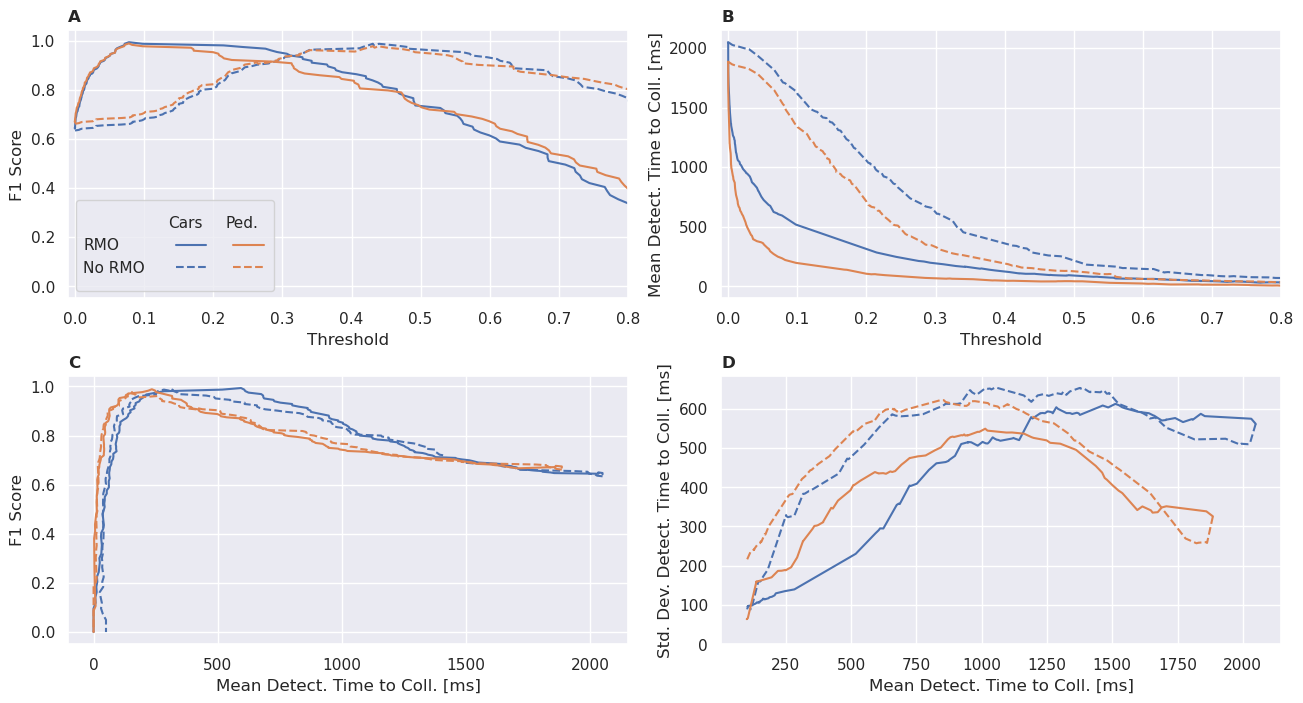

In [133]:
import matplotlib.patches as m_patches

fig, _ax = plt.subplots(2, 2, figsize=(13, 7))
ax = _ax.flatten()

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="RMO"),
    m_patches.Patch(color="none", label="No RMO"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Ped.")]

c_f1 = ax[0].plot(pr_car[2], f1_car, label="*", color=colors[0])
c_f1_linear = ax[0].plot(
    pr_car_linear[2], f1_car_linear, "--", label="*", color=colors[0]
)
patches_column2.extend([c_f1[0], c_f1_linear[0]])

p_f1 = ax[0].plot(pr_pedestrian[2], f1_pedestrian, label="*", color=colors[1])
p_f1_linear = ax[0].plot(
    pr_pedestrian_linear[2], f1_pedestrian_linear, "--", label="*", color=colors[1]
)
patches_column3.extend([p_f1[0], p_f1_linear[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")


sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th[df_th.coll_type == "cars"],
    legend=False,
    ax=ax[1],
    color=colors[0],
    linestyle="-",
)
sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th[df_th.coll_type == "pedestrians"],
    legend=False,
    ax=ax[1],
    color=colors[1],
    linestyle="-",
)

sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th_linear[df_th_linear.coll_type == "cars"],
    legend=False,
    ax=ax[1],
    color=colors[0],
    linestyle="--",
)
sns.lineplot(
    x="threshold",
    y="Detect. Time to Coll. [ms]",
    errorbar=None,
    data=df_th_linear[df_th_linear.coll_type == "pedestrians"],
    legend=False,
    ax=ax[1],
    color=colors[1],
    linestyle="--",
)

ax[2].plot(
    mean_first_detect_car["Detect. Time to Coll. [ms]"], f1_car, "-", color=colors[0]
)
ax[2].plot(
    mean_first_detect_car_linear["Detect. Time to Coll. [ms]"],
    f1_car_linear,
    "--",
    color=colors[0],
)

ax[2].plot(
    mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"],
    f1_pedestrian,
    "-",
    color=colors[1],
)
ax[2].plot(
    mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"],
    f1_pedestrian_linear,
    "--",
    color=colors[1],
)

ax[3].plot(
    mean_first_detect_car["Detect. Time to Coll. [ms]"][
        mean_first_detect_car["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_car["Detect. Time to Coll. [ms]"][
        mean_first_detect_car["Detect. Time to Coll. [ms]"] > 100
    ],
    "-",
    color=colors[0],
)
ax[3].plot(
    mean_first_detect_car_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_car_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_car_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_car_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    "--",
    color=colors[0],
)

ax[3].plot(
    mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_pedestrian["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian["Detect. Time to Coll. [ms]"] > 100
    ],
    "-",
    color=colors[1],
)
ax[3].plot(
    mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    sd_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"][
        mean_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"] > 100
    ],
    "--",
    color=colors[1],
)

# ax[3].plot(sd_first_detect_pedestrian["Detect. Time to Coll. [ms]"], f1_pedestrian, '-', color=colors[1])
# ax[3].plot(sd_first_detect_pedestrian_linear["Detect. Time to Coll. [ms]"], f1_pedestrian_linear, '--', color=colors[1])

ax[0].set_xlim(left=-0.01, right=0.8)
ax[1].set_xlim(left=-0.01, right=0.8)

ax[3].set_ylim(bottom=0.0)

ax[0].set_ylabel("F1 Score")
ax[0].set_xlabel("Threshold")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Mean Detect. Time to Coll. [ms]")

ax[2].set_xlabel("Mean Detect. Time to Coll. [ms]")
ax[2].set_ylabel("F1 Score")

ax[3].set_xlabel("Mean Detect. Time to Coll. [ms]")
ax[3].set_ylabel("Std. Dev. Detect. Time to Coll. [ms]")

ax[0].set_title("A", loc="left", fontweight="bold")
ax[1].set_title("B", loc="left", fontweight="bold")
ax[2].set_title("C", loc="left", fontweight="bold")
ax[3].set_title("D", loc="left", fontweight="bold")

fig.tight_layout(pad=0.5)

fig.savefig("f1_score_detect_time_emd.png", dpi=400)
fig.savefig("f1_score_detect_time_emd.pdf")

plt.show()

In [57]:
df_emd["positive"].unique()

array([0, 1])

In [47]:
df_th.columns

Index(['sample_id', 'coll_type', 'detect_time', 'threshold', 'model',
       'n tiles', 'tile_idx_y', 'tile_idx_x', 'coll_time', 'vel', 'diameter',
       'voltage', 'r left', 'r right', 'time', 'Output Voltage', 'L/v',
       'Collision Type', 'V Linear', 'Output Voltage Linear', 'positive'],
      dtype='object')

/tmp/ipykernel_3860/1709788399.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pr = pd.concat(
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fabian/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: u

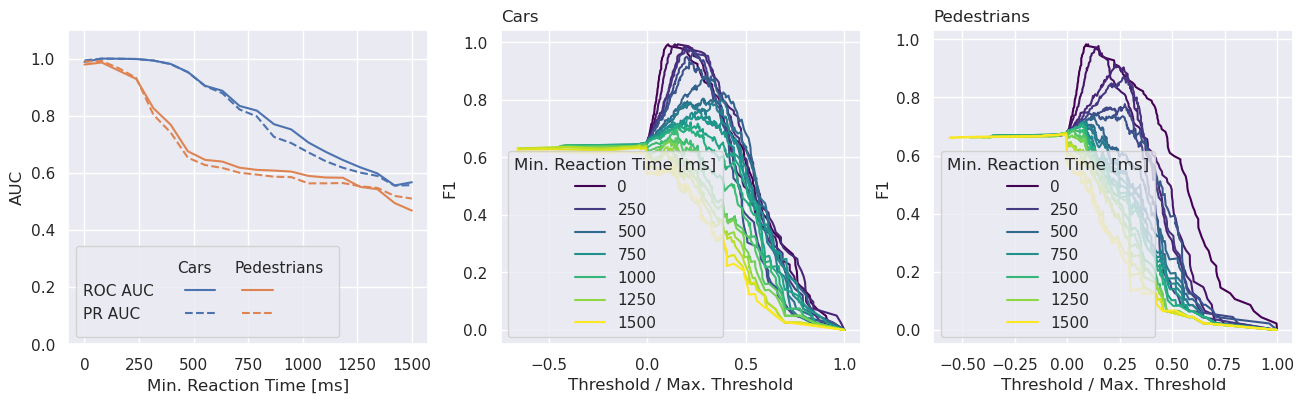

In [21]:
import matplotlib.patches as m_patches

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

patches_column1 = [
    m_patches.Patch(color="none", label=""),
    m_patches.Patch(color="none", label="ROC AUC"),
    m_patches.Patch(color="none", label="PR AUC"),
]
patches_column2 = [m_patches.Patch(color="none", label="Cars")]
patches_column3 = [m_patches.Patch(color="none", label="Pedestrians")]

fig, ax = plt.subplots(1, 3, figsize=(13, 4))

c_roc = ax[0].plot(min_react_time, roc_car, "-", c=colors[0], label="*")
c_aupr = ax[0].plot(min_react_time, aupr_car, "--", c=colors[0], label="*")
patches_column2.extend([c_roc[0], c_aupr[0]])
p_roc = ax[0].plot(min_react_time, roc_pedestrian, "-", c=colors[1], label="*")
p_aupr = ax[0].plot(min_react_time, aupr_pedestrian, "--", c=colors[1], label="*")
patches_column3.extend([p_roc[0], p_aupr[0]])

patches = []
patches.extend(patches_column1)
patches.extend(patches_column2)
patches.extend(patches_column3)

ax[0].set_ylim(top=1.1, bottom=0.0)

ax[0].set_ylabel("AUC")
ax[0].set_xlabel("Min. Reaction Time [ms]")
lg = ax[0].legend(
    ncol=3,
    handles=patches,
    handletextpad=-2.5,
    borderpad=1.0,
)

for i, text in enumerate(lg.get_texts()):
    if i in (4, 5, 7, 8):
        text.set_color("none")

cmap = plt.get_cmap("viridis")

df_pr = pd.DataFrame(columns=["recall", "precision", "model", "Min. Reaction Time [ms]", "coll_type", "F1", "Threshold / Max. Threshold"])
for i, pr in enumerate(pr_curve_sweep_car):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "cars",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

for i, pr in enumerate(pr_curve_sweep_pedestrian):
    df_pr = pd.concat(
        [
            df_pr,
            pd.DataFrame(
                {
                    "recall": pr[1][1:],
                    "precision": pr[0][1:],
                    "model": "EMD",
                    "Min. Reaction Time [ms]": min_react_time[i],
                    "coll_type": "pedestrians",
                    "F1": 2 * pr[0][1:] * pr[1][1:] / (pr[0][1:] + pr[1][1:]),
                    "Threshold / Max. Threshold": pr[2]/pr[2].max(),
                }
            ),
        ], ignore_index=True
    )

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="cars"], ax=ax[1], hue="Min. Reaction Time [ms]", palette="viridis")

sns.lineplot(x="Threshold / Max. Threshold", y="F1", data=df_pr[df_pr.coll_type=="pedestrians"], ax=ax[2], hue="Min. Reaction Time [ms]", palette="viridis") 

ax[1].set_title("Cars", loc="left")
ax[2].set_title("Pedestrians", loc="left")

#ax[1].set_xlim(right=0.2)

fig.tight_layout(pad=0.5)
fig.savefig("roc_pr_emd_linear.png", dpi=400)
fig.savefig("roc_pr_emd_linear.pdf")
plt.show()

In [4]:
def gen_evt_hist(evts: np.ndarray, t: float, dt: float, w: int, h: int) -> np.ndarray:
    evts_filt = evts[(evts["t"] >= t) & (evts["t"] < (t + dt))]

    hist = np.histogram2d(
        evts_filt["x"],
        evts_filt["y"],
        bins=[np.arange(w + 1), np.arange(h + 1)],
        weights=evts_filt["p"].astype("i1") * 2 - 1,
    )

    img = np.minimum(1.0, np.maximum(-1.0, hist[0].T))

    return img

In [43]:
data_car_passing = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_car_passing.npz"))

idx_start = 100
idx_end = 250

V_passing = data_car_passing["V"][idx_start:idx_end]
r_left_passing = data_car_passing["r_left"][idx_start:idx_end]
r_right_passing = data_car_passing["r_right"][idx_start:idx_end]
V_linear_passing = 0.5 * (r_left_passing + r_right_passing)

t_ms_passing = np.arange(0, len(V_passing)) * 10.0

events_passing = data_car_passing["events"]

data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start = 75
idx_end = -1

V_turn = data_right_turn["V"][idx_start:idx_end]
r_left_turn = data_right_turn["r_left"][idx_start:idx_end]
r_right_turn = data_right_turn["r_right"][idx_start:idx_end]
V_linear_turn = 0.5 * (r_left_turn + r_right_turn)

t_ms_turn = np.arange(0, len(V_turn)) * 10.0

events_turn = data_right_turn["events"]

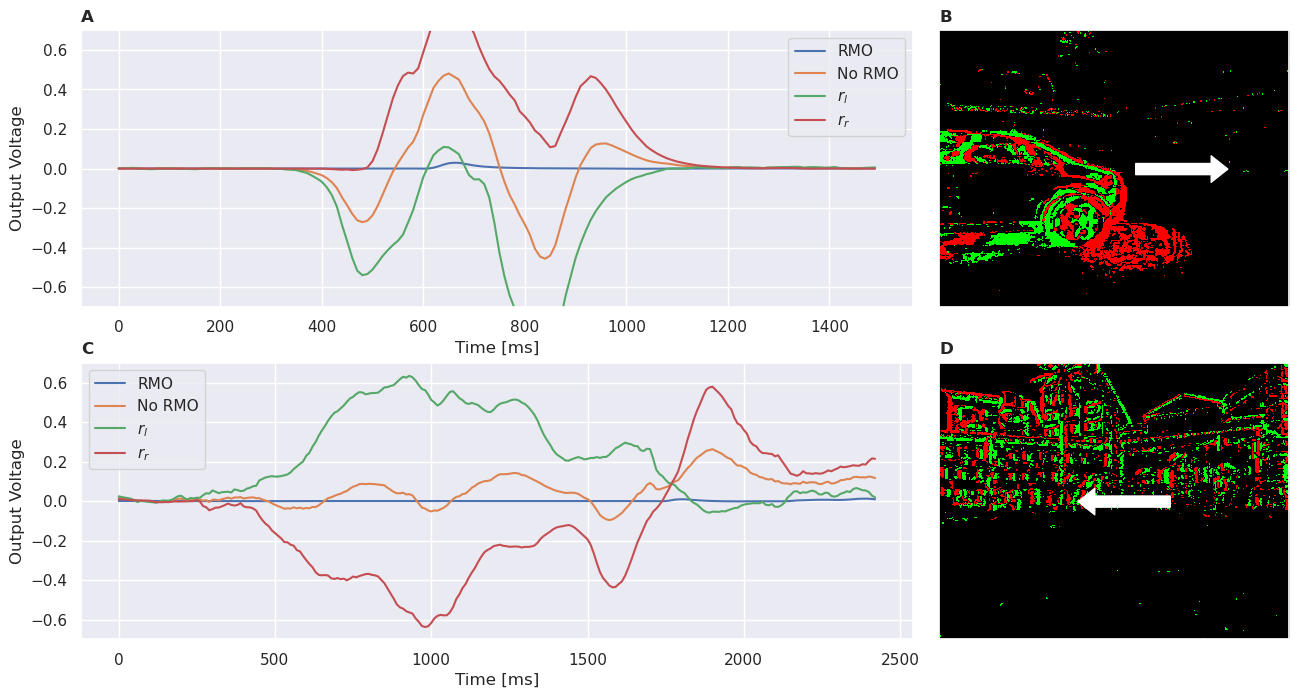

In [65]:
from matplotlib.colors import ListedColormap

cmap_evts = ListedColormap([(1,0,0), "black", (0,1,0)])

fig = plt.figure(figsize=(13, 7))


w_l = 0.64
w_r = 0.4
m_l = 0.065
m_r = 0.66
m_b = 0.08
m_t = 0.5 + m_b - 0.025
h = 0.5 - m_b - 0.025

ax = []
ax.append(fig.add_axes([m_l, m_t, w_l, h]))
ax.append(fig.add_axes([m_r, m_t, w_r, h]))
ax.append(fig.add_axes([m_l, m_b, w_l, h]))
ax.append(fig.add_axes([m_r, m_b, w_r, h]))


#fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].plot(t_ms_passing, V_passing, label="RMO")
ax[0].plot(t_ms_passing, V_linear_passing, label="No RMO")
ax[0].plot(t_ms_passing, r_left_passing, label="$r_l$")
ax[0].plot(t_ms_passing, r_right_passing, label="$r_r$")

ax[0].legend()

ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Output Voltage")

ax[0].set_ylim(-0.7, 0.7)

img = gen_evt_hist(events_passing[180000:190000], 0., 20., 304, 240)

ax[1].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[1].grid(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].annotate(None,xy=(250,120),xytext=(170,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

ax[2].plot(t_ms_turn, V_turn, label="RMO")
ax[2].plot(t_ms_turn, V_linear_turn, label="No RMO")
ax[2].plot(t_ms_turn, r_left_turn, label="$r_l$")
ax[2].plot(t_ms_turn, r_right_turn, label="$r_r$")

ax[2].legend()

ax[2].set_xlabel("Time [ms]")
ax[2].set_ylabel("Output Voltage")

ax[2].set_ylim(-0.7, 0.7)

img = gen_evt_hist(events_turn[180000:190000], 0., 20., 304, 240)

ax[3].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[3].grid(False)

ax[3].set_xticks([])
ax[3].set_yticks([])

ax[3].annotate(None,xy=(120,120),xytext=(200,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

#fig.tight_layout(pad=0.5)

for i, c in enumerate("ABCD"):
    ax[i].set_title(c, loc="left", fontweight="bold")

fig.savefig("car_passing_turn.png", dpi=400)
fig.savefig("car_passing_turn.pdf")

plt.show()

In [41]:
data_right_turn = np.load(os.path.join(sim_manual_rec_fold, "recorded_live_demo_right_turn.npz"))

idx_start = 75
idx_end = -1

V = data_right_turn["V"][idx_start:idx_end]
r_left = data_right_turn["r_left"][idx_start:idx_end]
r_right = data_right_turn["r_right"][idx_start:idx_end]
V_linear = 0.5 * (r_left + r_right)

t_ms = np.arange(0, len(V)) * 10.0

events = data_right_turn["events"]

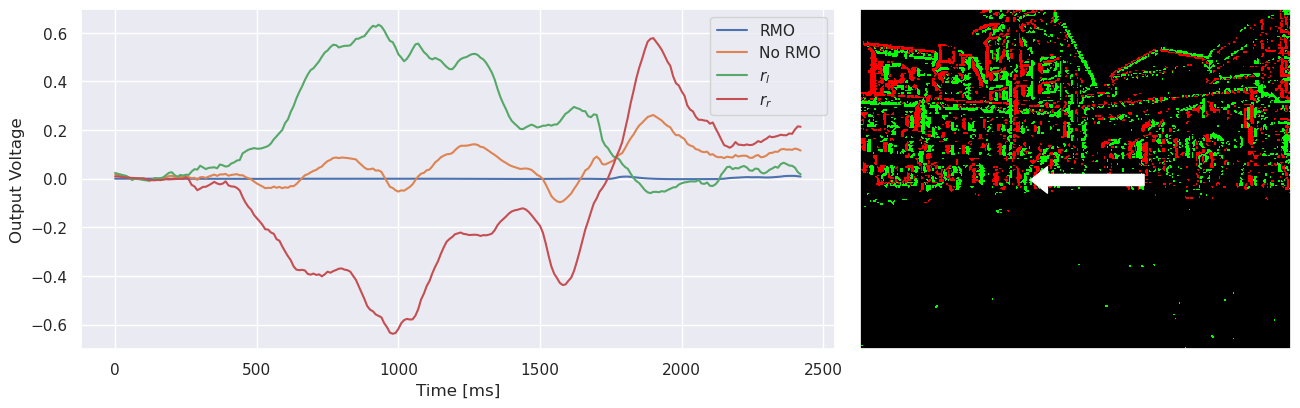

In [42]:
from matplotlib.colors import ListedColormap

cmap_evts = ListedColormap([(1,0,0), "black", (0,1,0)])

fig = plt.figure(figsize=(13, 4))

ax = []
ax.append(fig.add_axes([0.065, 0.14, 0.58, 0.85]))
ax.append(fig.add_axes([0.63, 0.14, 0.4, 0.85]))

#fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].plot(t_ms, V, label="RMO")
ax[0].plot(t_ms, V_linear, label="No RMO")
ax[0].plot(t_ms, r_left, label="$r_l$")
ax[0].plot(t_ms, r_right, label="$r_r$")

ax[0].legend()

ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Output Voltage")

img = gen_evt_hist(events[180000:190000], 0., 20., 304, 240)

ax[1].imshow(img, cmap=cmap_evts, vmin=-1.0, vmax=1.0)
ax[1].grid(False)

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].annotate(None,xy=(120,120),xytext=(200,120),arrowprops={"width": 8, "headwidth": 19, "color": "white"})

#fig.tight_layout(pad=0.5)

fig.savefig("car_right_turn.png", dpi=400)
fig.savefig("car_right_turn.pdf")

plt.show()